In [19]:
from ppi.database import Database
from ppi.intact_analyzer import IntActAnalyzer
import pandas as pd

PATH_TO_FILE = "../data/ppi.zip"

# Protein-protein interaction analyzer

**Table of contents**<a id='toc0_'></a>    
- [Get DataFrames from file](#toc1_)    
- [Graph](#toc2_)    
  - [Whole graph](#toc2_1_)    
  - [Filter graph for ...](#toc2_2_)    
    - [Detection method](#toc2_2_1_)    
    - [Confidence value](#toc2_2_2_)    
    - [Interaction type](#toc2_2_3_)    
    - [PubMed Identifier (pmid)](#toc2_2_4_)    
- [Protein with highest Betweenness Centrality](#toc3_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [20]:
db = Database()
db.set_path_to_data_file(PATH_TO_FILE)

True

## <a id='toc1_'></a>[Get DataFrames from file](#toc0_)

In [21]:
# read from file
db.get_proteins()

,accession,name,taxid
id,,,
1,A0A0B4J2F0,Protein PIGBOS1,9606
2,A0A0H3JRU9,Pyruvate carboxylase,158878
3,A0A0H3K9R3,RuBisCO chaperone RbcX,269084
4,A0A0U1RRE5,Negative regulator of P-body association,9606
5,A0A1L8F5J9,"Glutamate receptor ionotropic, NMDA 1",8355
...,...,...,...
13434,T2G899,Adenylylsulfate reductase subunit beta,1121448
13435,W0T9X4,Serine/threonine-protein kinase ATG1,1003335
13436,W0TA43,Autophagy-related protein 13,1003335


In [22]:
# read from file
db.get_interactions()

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "d:\Programming Lab II\ppi\.venv\Lib\site-packages\IPython\core\interactiveshell.py", line 3550, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\mehme\AppData\Local\Temp\ipykernel_14584\3528466325.py", line 2, in <module>
    db.get_interactions()
  File "D:\Programming Lab II\ppi\src\ppi\database.py", line 203, in get_interactions
    interactions: pd.DataFrame = df.loc[:, columns]
                                   ^^^^^^^^^^^^^^^^
  File "d:\Programming Lab II\ppi\.venv\Lib\site-packages\pandas\core\frame.py", line 10034, in apply
    return op.apply().__finalize__(self, method="apply")
           ^^^^^^^^^^
  File "d:\Programming Lab II\ppi\.venv\Lib\site-packages\pandas\core\apply.py", line 837, in apply
    return self.apply_standard()
           ^^^^^^^^^^^^^^^^^^^^^
  File "d:\Programming Lab II\ppi\.venv\Lib\site-packages\pandas\core\apply.py", line 963, in apply_standard
    results, res_index = self

In [ ]:
db.import_data()

## <a id='toc2_'></a>[Graph](#toc0_)

### <a id='toc2_1_'></a>[Whole graph](#toc0_)

In [ ]:
db.import_data()


Run time to draw the whole graph is too long (>5min). 

### <a id='toc2_2_'></a>[Filter graph for ...](#toc0_)

#### <a id='toc2_2_1_'></a>[Detection method](#toc0_)

In [ ]:
db.get_detection_method_statistics().iloc[20:30]

,number
detection_method,
classical fluorescence spectroscopy,38
atomic force microscopy,1
protein kinase assay,192
isothermal titration calorimetry,134
barcode fusion genetics two hybrid,122
light scattering,18
x ray scattering,33
two hybrid pooling approach,1215
bimolecular fluorescence complementation,77


As an example we select [ELISA](https://en.wikipedia.org/wiki/ELISA), a commonly used analytical biochemistry assay, first described in 1971.

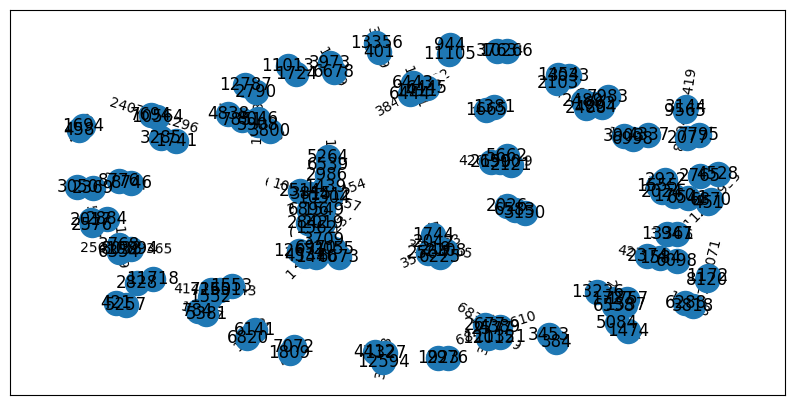

In [ ]:
graph = db.get_graph(detection_method='enzyme linked immunosorbent assay')
iaa = IntActAnalyzer(graph)
iaa.draw_graph()

In [ ]:
df = pd.read_sql("Select * from interaction where detection_method='enzyme linked immunosorbent assay'", db.engine)
print("Number of entries: ", df.shape[0])
df_pmid = df.value_counts('pmid', sort=True, ascending=False)
df_pmid.head()

Number of entries:  114


pmid
25009770.0    6
28533443.0    5
31273197.0    3
22518841.0    3
23086448.0    3
Name: count, dtype: int64

Publication with most entries

In [ ]:
pmid = int(df_pmid.index[0])
print(f"https://pubmed.ncbi.nlm.nih.gov/{pmid}/")

https://pubmed.ncbi.nlm.nih.gov/25009770/



*FEBS Open Bio. 2014 Jun 6:4:571-83.doi: 10.1016/j.fob.2014.05.005. eCollection 2014.*

**Discovery of novel interacting partners of PSMD9, a proteasomal chaperone: Role of an Atypical and versatile PDZ-domain motif interaction and identification of putative functional modules**

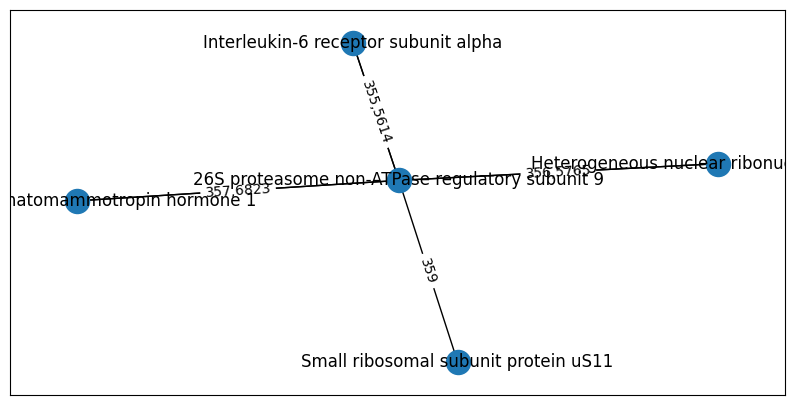

In [ ]:
graph_filtered_for_pubication = db.get_graph(pmid=25009770)
IntActAnalyzer(graph_filtered_for_pubication).draw_graph(node_label='name')

#### <a id='toc2_2_2_'></a>[Confidence value](#toc0_)

Note that the parameter for `get_graph`  is **confidence_value_gte** (= means confidence_value greater than or equals), but the in `draw_graph` **edge_label = 'confidence_value'**

In [ ]:
df = db.get_confidence_value_statistics()
df.head()

,number
confidence_value,
0.63,1023
0.86,390
0.60,2208
0.64,2277
0.61,1609


number of edges 11


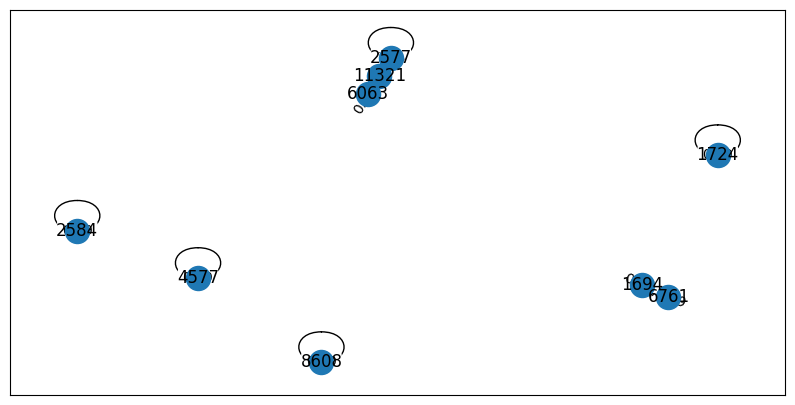

In [ ]:
graph = db.get_graph(confidence_value_gte=0.99)
print('number of edges', graph.number_of_edges())
iaa = IntActAnalyzer(graph)
iaa.draw_graph(edge_label='confidence_value')

Let's check why we have this this little cycles.

In [ ]:
sql = """Select
    a.name protein_a, 
    b.name protein_b,
    i.detection_method,
    i.interaction_type
from 
    interaction i inner join 
    protein a on (i.protein_a_id=a.id) 
    inner join protein b on (i.protein_b_id=b.id) 
where 
    i.confidence_value=0.99
group by
    protein_a, 
    protein_b"""
pd.read_sql(sql, db.engine)

,protein_a,protein_b,detection_method,interaction_type
0,Alpha-synuclein,Alpha-synuclein,cosedimentation,direct interaction
1,Amyloid-beta precursor protein,Amyloid-beta precursor protein,electron microscopy,colocalization
2,Angiotensin-converting enzyme 2,Spike glycoprotein,pull down,direct interaction
3,Cellular tumor antigen p53,E3 ubiquitin-protein ligase Mdm2,x-ray crystallography,direct interaction
4,E3 ubiquitin-protein ligase Mdm2,Cellular tumor antigen p53,surface plasmon resonance,direct interaction
5,Leucine-rich repeat serine/threonine-protein k...,Leucine-rich repeat serine/threonine-protein k...,anti tag coimmunoprecipitation,physical association
6,Nucleoprotein,Nucleoprotein,two hybrid,physical association
7,Spike glycoprotein,Angiotensin-converting enzyme 2,surface plasmon resonance,direct interaction
8,Spike glycoprotein,Spike glycoprotein,3D electron microscopy,direct interaction


In the result list we can see that there seems to be several self interaction (dimers). To exclude these interaction from the graph we can use the argument `disallow_self_interaction`  from `get_graph` method.

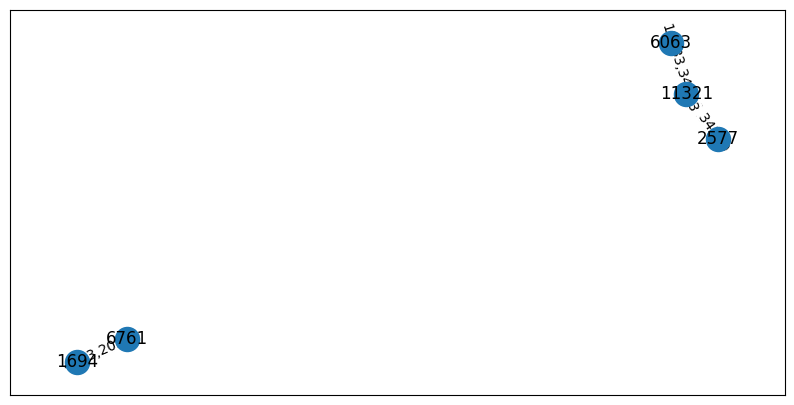

In [ ]:
graph = db.get_graph(confidence_value_gte=0.99, disallow_self_interaction=True)
IntActAnalyzer(graph).draw_graph()

#### <a id='toc2_2_3_'></a>[Interaction type](#toc0_)

In [ ]:
df = db.get_interaction_type_statistics()
df.head(10)

,number
interaction_type,
physical association,25037
direct interaction,3498
association,10431
colocalization,388
phosphorylation reaction,208
proximity,211
covalent binding,12
cleavage reaction,30
methylation reaction,14


We select here [ubiquitination reaction](https://en.wikipedia.org/wiki/Ubiquitin#Ubiquitylation)

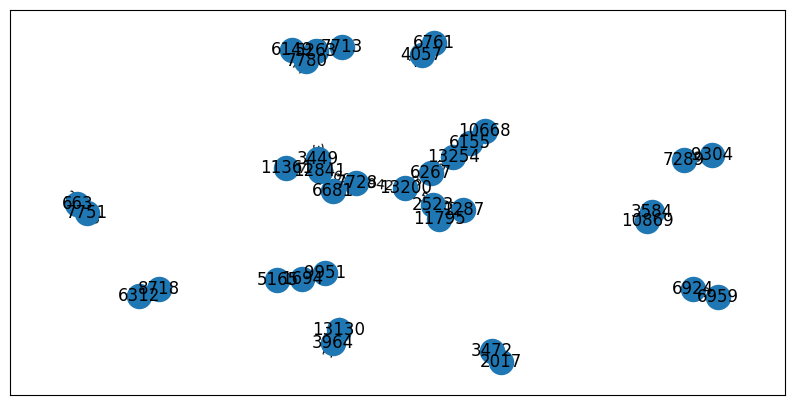

In [ ]:
graph = db.get_graph(interaction_type='ubiquitination reaction')
iaa = IntActAnalyzer(graph)
iaa.draw_graph()

#### <a id='toc2_2_4_'></a>[PubMed Identifier (pmid)](#toc0_)

In [ ]:
db.get_pmid_statistics().iloc[100:105]

KeyError: nan

We select [pmid 16273093](https://pubmed.ncbi.nlm.nih.gov/16273093/):


*Nature. 2006 Jan 12;439(7073):168-74.doi: 10.1038/nature04177. Epub 2005 Nov 6.*

**A quantitative protein interaction network for the ErbB receptors using protein microarrays**

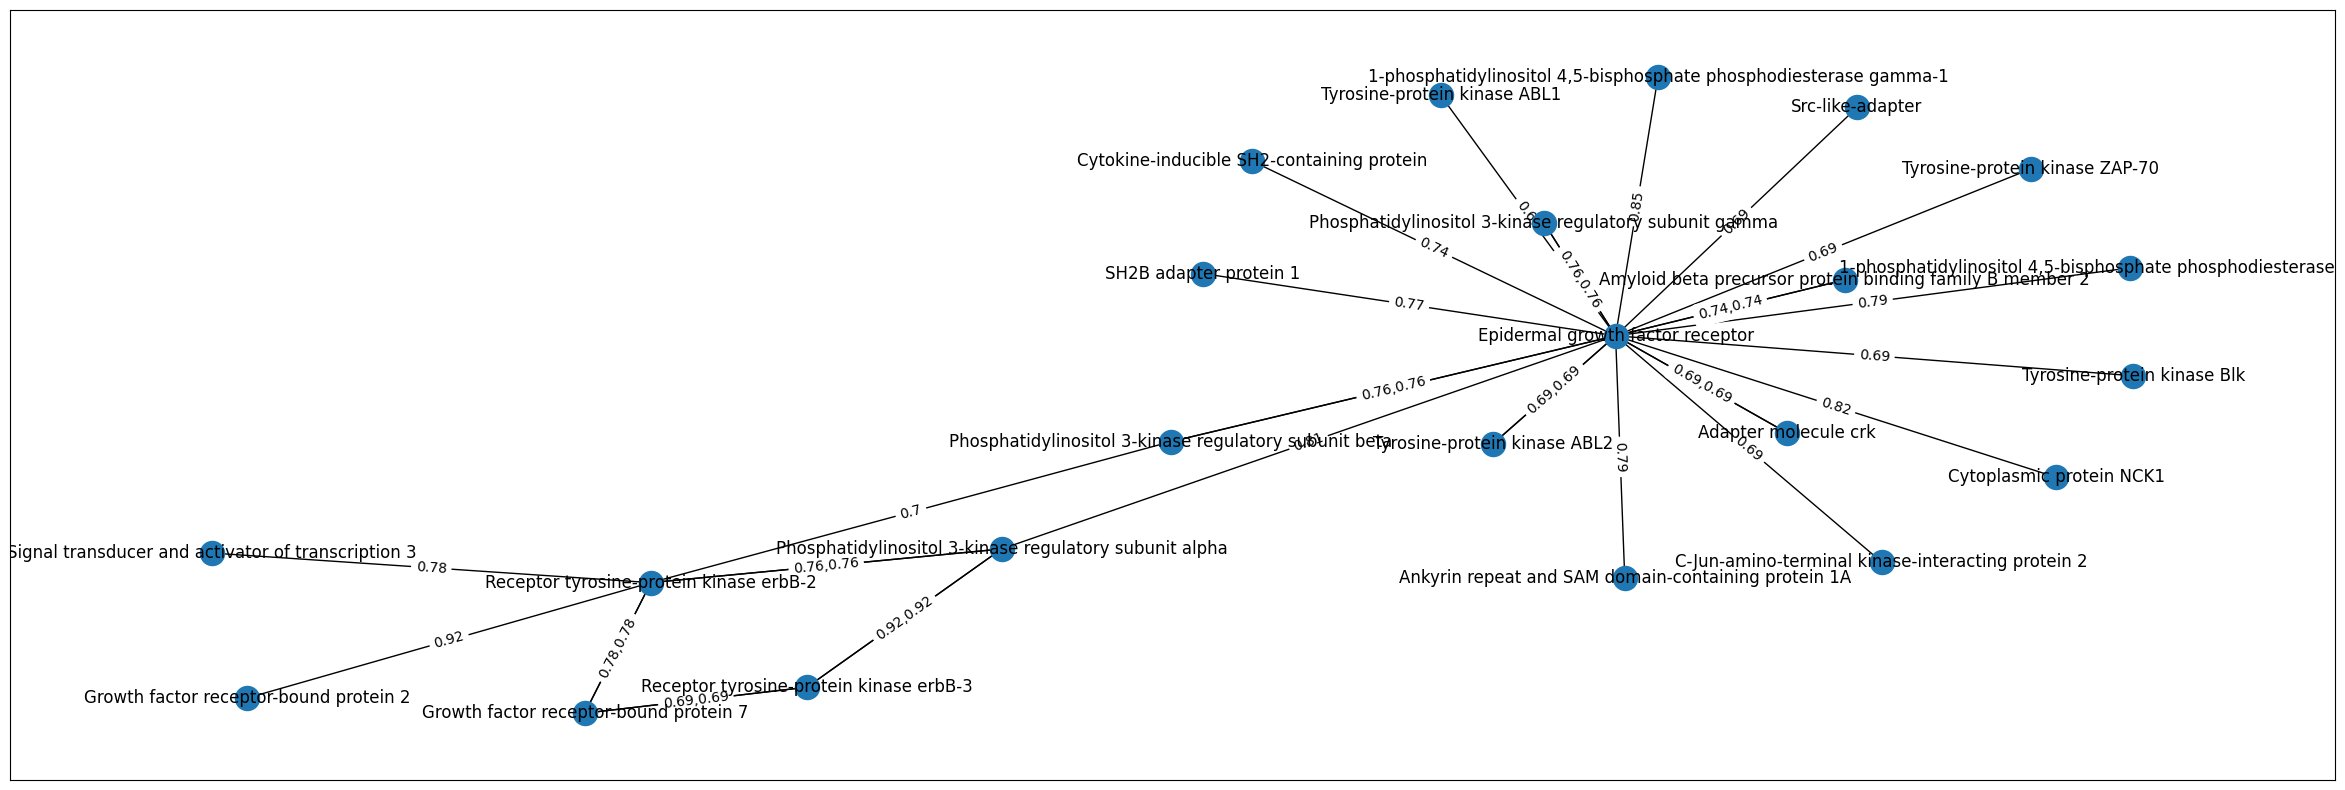

In [ ]:
graph = db.get_graph(pmid='16273093')
iaa = IntActAnalyzer(graph)
iaa.draw_graph(node_label='name', edge_label='confidence_value', figsize=(30,10))

## <a id='toc3_'></a>[Protein with highest Betweenness Centrality](#toc0_)

### Protein with highest beetweeness centrality

In [ ]:
graph = db.get_graph(pmid='16273093')
iaa = IntActAnalyzer(graph)
iaa.get_protein_with_highest_bc()

{'accession': 'P00533',
 'name': 'Epidermal growth factor receptor',
 'taxid': 9606,
 'node_id': 1393,
 'bc_value': 0.9126984126984126}

The result fits to the topic of the [paper](https://pubmed.ncbi.nlm.nih.gov/16273093/)

### Neighbors names

In [ ]:
iaa.get_neighbors_name('Epidermal growth factor receptor')

['Phosphatidylinositol 3-kinase regulatory subunit beta',
 'Tyrosine-protein kinase ABL1',
 'Cytoplasmic protein NCK1',
 '1-phosphatidylinositol 4,5-bisphosphate phosphodiesterase gamma-2',
 '1-phosphatidylinositol 4,5-bisphosphate phosphodiesterase gamma-1',
 'Tyrosine-protein kinase ABL2',
 'Adapter molecule crk',
 'C-Jun-amino-terminal kinase-interacting protein 2',
 'Phosphatidylinositol 3-kinase regulatory subunit gamma',
 'Amyloid beta precursor protein binding family B member 2',
 'Cytokine-inducible SH2-containing protein',
 'Phosphatidylinositol 3-kinase regulatory subunit alpha',
 'Tyrosine-protein kinase ZAP-70',
 'Tyrosine-protein kinase Blk',
 'Src-like-adapter',
 'Ankyrin repeat and SAM domain-containing protein 1A',
 'SH2B adapter protein 1']